<a href="https://colab.research.google.com/github/OlaKlingberg/Topic-Modeling-the-National-Conversation/blob/main/Topic_Modeling_the_National_Conversation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Did the Queer Conversation Change after the 2016 Election? – A Topic Modeling Project**
2024-11-27

GitHub repository: [Topic-Modeling-the-National-Conversation](https://github.com/OlaKlingberg/DTSA-5510-Topic-Modeling-the-National-Conversation)

In this project, I will compare the public conversation about queer issues before and after the 2016 U.S. presidential election. I will be using a dataset consisting of headlines and short descriptions of articles from HuffPost (formerly Huffington Post) from January 28, 2012 to May 25, 2018. I will look at articles labeled as belonging to the category “queer voices” and extract themes from two subsets: before and after the day of the election, November 8, 2016.

The choice of date to split on is somewhat arbitrary. If the goal had been to compare the conversation under president Obama and president Trump, then inauguration day, January 20, 2017, might have been a more appropriate cutoff. On the other hand, if the goal were to study the difference between before and after Trump’s appearance in U.S. politics, then one might have split on June 16, 2015, the day he announced his candidacy, or on May 3, 2016, the day that the other remaining Republican candidates dropped out of the primary race, effectively securing Trump’s nomination.

The reason I decided to use election date as the cutoff is that up until that day, Hillary Clinton was favored to win, in polls as well as on betting markets. So the day of the election (or rather the night after it) was when the perception of who would become president changed, from probably Clinton to definitely Trump. I want to see if this change led to a change in the conversation about queer issues.



# **Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Installs and imports**


In [ ]:
# Remove some libraries that cause conflicts.
# !pip uninstall -y numba
# !pip uninstall -y tensorflow

In [ ]:
!pip install lda -q
!pip install "tmtoolkit[recommended]" -q
!pip install pyLDAvis -q
!pip install langdetect -q
!pip install textblob -q
!pip install datasets -q

In [ ]:
# !pip uninstall numpy
# !pip install numpy==1.25.2

In [ ]:
# General libaries
from time import time
import gzip
import json
import itertools
import numpy as np
import pandas as pd
import pickle
import textwrap
from IPython.display import Markdown, display, clear_output
import lda
from datetime import datetime
import pytz
import os
from datasets import load_dataset
import re
import warnings

# Scikit Learn
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_distances

# Tmtoolkit
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, \
    filter_clean_tokens, dtm, vocabulary, remove_tokens
from tmtoolkit.topicmod import tm_lda
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.visualize import parameters_for_ldavis, plot_eval_results

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Other NLP
# from langdetect import detect
import string
from string import punctuation
from textblob import TextBlob

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Machine Learning
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **Configurations**

All configurations for the topic modeling, including the selection of the data, are set in the code block below. Here are explanations of their meanings:

**General configs**
* **MODEL_TYPE:** Type of topic modeling: 'lda' for Latent Dirichlit Allocation; 'nmf' for Non-Negative Matrix Factorization
* **CATEGORY:** Name of the article category to load. I will be working with "QUEER VOICES".
* **DF_PART:** Which part of the dataset should be loaded: 'all' for the entire time period; 'before' for articles up till the election day November 8, 2016; 'after' for articles after the election day.
* **N_TOPICS:** Number of topics to generate.
* **MIN_DF:** The minimum portion of the texts a token must appear in for it to be used in the modeling.
* **MAX_DF:** The maximum portion of the texts a token may appear in for it to be used in the modeling.
* **MAX_FEATURES:** The maximum number of features (tokens) to include in the modeling.
* **MAX_N_GRAMS:** The longest n-grams to include in the modeling. I have used 2, meaning the modeling is based on unigrams and bigrams.
* **CUSTOM_STOPWORDS:** Stopwords to add to the list of stopwords I download from NLTK. I have added some special characters that otherwise managed to pass through the data cleaning to this list.
* **CUSTOM_NON_STOPWORDS:** Words to remove from the NLTK list of stopwords. I remove "same", as that word appears in phrases like "same sex marriage" which could be meaningful in this data.
* **TOP_N_WORDS:** Number of top words to consider for each topic.
* **TOPICS_RANGE_L:** What is the lowest number of topics that should be considered when evaluating a model?
* **TOPICS_RANGE_H:** What is the highest number of topics that should be considered when evaluating a model?

**Only for LDA**
* **LAMBDA_:** The specificity of the tokens used for topic labels, from 0: most specific, to 1: most general.
* **ETA:** A hyperparameter that defines the prior for the topic-word distribution. A smaller value encourages sparsity in the distribution (fewer words per topic), while a larger value leads to a more even distribution across all words.
* **ITERATIONS:** The number of iterations the model performs. Higher values can improve convergence and result in better topics but increase computation time.
* **PASSES:** The number of times the entire corpus is passed through the model during training. Increasing passes can help refine the model, especially if the dataset is small or the topics are not well-separated after the initial iterations.

**Only for NMF**
* **SOLVER:** The optimization method used to factorize the document-term matrix.
* **INIT:** The initialization method for the NMF decomposition.
* **BETA_LOSS:** The loss function.
* **NMF_ALPHA:** A regularization parameter that applies to both the document-topic matrix (W) and topic-word matrix (H). It controls overfitting by adding a penalty for large values in these matrices, encouraging simpler solutions.
* **L1_RATIO:** Specifies the balance between L1 and L2 regularization. A value of 0 applies only L2 regularization, while 1 applies only L1.


**Automatically generated**
* **DF_NAME:** Name to use when saving results; based on the CATEGORY.
* **timestamp:** A timestamp which will be included in the name of all files saved.


In [ ]:
# Models to run
MODEL_TYPE          = 'nmf' # 'lda', 'nmf'

# General configs
CATEGORY            = 'QUEER VOICES'
DF_PART             = 'after' # 'all', 'before', or 'after'
N_TOPICS            = 8
MIN_DF              = 0.005
MAX_DF              = 0.1
MAX_FEATURES        = 10000 # 10000, 5000, 15000
MAX_N_GRAMS         = 2
CUSTOM_STOPWORDS    = ['“', '‘', 'audio'] # Add to the NLTK stopwords list. (Based on early testing.)
CUSTOM_NON_STOPWORDS= ['same'] # Remove from standard the NLTK stopwords list. (Not to filter out "same sex")
TOP_N_WORDS         = 5
TOPICS_RANGE_L      = 8
TOPICS_RANGE_H      = 21

# Only for LDA
LAMBDA_             = 1
ETA                 = 0.1 # 1 / N_TOPICS, 0.1, 0.01
ITERATIONS          = 500, # Start with 500. Possibly increase
PASSES              = 10 # Start with 10. Possibly increase

# Only for NMF
SOLVER              = 'mu' # 'mu' (better for sparse datasets), 'cd'.
INIT                = 'nndsvda' # 'nndsvd', 'random', 'nndsvda', 'nndsvdar', None. If SOLVER = 'mu', don't use 'nndsvd'
BETA_LOSS           = 'frobenius' # 'frobenius', 'kullback-leibler', 'itakura-saito'
NMF_ALPHA           = 0 # 0 gives best results in early testing
L1_RATIO            = 0 # 0 gives best results in early testing

# Automatically generated
DF_NAME = CATEGORY.lower().replace(' ', '_')

# Timestamp, to be used in the file names of all generated files
timestamp = datetime.now(pytz.timezone('US/Eastern')).strftime('%Y-%m-%d_%H%M')

# **Data and Data Cleaning**

The dataset is available at HuggingFace: HuffPost. It has 200,853 rows and 7 columns. I will work with the 6,314 rows in the category “QUEER VOICES”.

I will be using these columns:
* **category:** categorical: string.
* **headline:** the headline of the article; string
* **short_description:** a short statement about the content of the article; string
* **date:** publication date in YYYY-MM-DD format; string

The data has these columns which I will not be using:
* **0:** duplicate of the index
* **authors:** the article author(s); string
* **link:** the article’s URL; string

As both the headline and the short description contain words pertaining to the contents of the article, they could both be used for topic modeling. To avail myself of the content of both fields, I will concatenate them into one text.

There are no missing values in the columns I intend to use.

During Natural Language Processing (NLP), texts are often cleaned by removing punctuation marks, and sometimes all non-alpha characters and also stopwords, and by lowercasing all text. I will leave the text columns as they are in the dataset, for human readability, and perform the cleaning on the fly, so to speak, while building the corpus which is the base for the topic modeling.


## **Directories**

In [ ]:
# Main directory used for submission
PROJECT_DIR = "/content/drive/MyDrive"

# My directory on my local machine
# PROJECT_DIR = "/content/drive/MyDrive/Colab/Boulder/21. Unsupervised Algorithms in Machine Learning/21. Final Project"

# Subdirectories
DATA_DIR = f"{PROJECT_DIR}/data"
GENERATED_DIR = f"{PROJECT_DIR}/generated_files"

## **Load the data**

The first time I load the data, I generate a dataframe with only those rows I will work with (those in the category "QUEER VOICES") and save it to disk. This makes futures retrieval faster.

To this filtered dataframe, I add these columns:
* **headline_and_desc:** the headline concatenated with the short description; this is the column I will use for the topic modeling.
* **word_count:** the word count of the headline_and_desc field.
* **char_count:** the character count of the headline_and_desc filed.



In [ ]:
def load_full_dataset_filter_and_save(category):
    """
    Loads the full dataset, filters it by the specified category, adds additional columns for analysis,
    and saves the filtered dataset to disk.

    Parameters:
    ----------
    category : str
        The category to filter the dataset by (e.g., 'QUEER VOICES').

    Returns:
    -------
    pandas.DataFrame
        A DataFrame containing rows that belong to the specified category, with additional columns for analysis.

    Notes:
    -----
    - The dataset is loaded using the `load_dataset` function.
    - Rows are filtered to include only those that belong to the specified `category`.
    - The following new columns are added:
        - `headline_and_desc`: A concatenation of the 'headline' and 'short_description' columns.
        - `word_count`: The word count of the `headline_and_desc` column.
        - `char_count`: The character count of the `headline_and_desc` column.
    - The DataFrame is sorted by the 'date' column in ascending order.
    - The filtered dataset is saved to disk as a CSV file in the specified `DATA_DIR` directory.
      The filename is derived from the category name, converted to lowercase with spaces replaced by underscores.
    """
    # Load the full dataset
    ds = load_dataset('khalidalt/HuffPost')
    df = pd.DataFrame(ds['test'])

    # Group by category
    df.groupby('category').count().sort_values(by = 'headline', ascending = False)

    # Extract articles belonging to the chosen category
    df = df[df['category'] == category].copy()

    # Concatenate the headline and short description into one text
    df['headline_and_desc'] = df['headline'] + '. ' + df['short_description']

    # Add cols for word count and character count
    df['word_count'] = df['headline_and_desc'].apply(lambda x: len(x.split()))
    df['char_count'] = df['headline_and_desc'].apply(lambda x: len(x))

    # Sort the df by date
    df = df.sort_values(by = 'date', ascending = True)

    # Generate a filename: the category, lowercased
    file_name = category.lower().replace(' ', '_')

    # Save the df with the selected category to disk and return it
    df.to_csv(f"{os.path.join(DATA_DIR, file_name)}.csv")
    return df

In [ ]:
# Load the df for the selected topic, if it exists
try:
    df = pd.read_csv(f"{os.path.join(DATA_DIR, DF_NAME)}.csv")
    print(f"Loading saved df {DF_NAME}.")
except:
    # There is no df for the selected topic, so load the full dataset and create a df for the selected topic
    print(f"No df has been saved for category {CATEGORY}. Loading full data set.")
    df = load_full_dataset_filter_and_save(CATEGORY)

# Select a part
if DF_PART == 'all':
    pass
elif DF_PART == 'before':
    df = df[df['date'] <= '2016-11-08']
elif DF_PART == 'after':
    df = df[df['date'] > '2016-11-08']
else:
    print("Invalid DF_PART")

# Reset the index
df = df.reset_index(drop = True)

Loading saved df queer_voices.


# **Exploratory Data Analysis**

The data looked at below is the one in dataframe that has already been filtered on CATEGORY, and where I have added some columns, as described above.

## **Dimensions and distribution**

In [ ]:
# Dimensions of the data
rows_n, columns_n = df.shape
print(f"Number of rows: {rows_n}.")
print(f"Number of columns: {columns_n}")


Number of rows: 2068.
Number of columns: 11


In [ ]:
# Output the first few rows
df.head()

,Unnamed: 0,category,headline,authors,link,short_description,date,label,headline_and_desc,word_count,char_count
0,42994,QUEER VOICES,Dear Queer America: Here Is What We Must Do No...,Noah Michelson,https://www.huffingtonpost.com/entry/queer-ame...,"Let us never stop fighting, even when the end ...",2016-11-09,7,Dear Queer America: Here Is What We Must Do No...,29,153
1,42931,QUEER VOICES,The Unclear Future of Trans Rights Under Trump,NaN,https://www.huffingtonpost.comhttps://broadly....,"Two years ago, a black trans woman was photogr...",2016-11-09,7,The Unclear Future of Trans Rights Under Trump...,29,169
2,42912,QUEER VOICES,A Gay Immigrant’s Perspective On Trump's Elect...,"Keay Nigel, ContributorSingaporean gay writer ...",https://www.huffingtonpost.com/entry/a-gay-imm...,I think it’s highly unlikely that marriage equ...,2016-11-10,7,A Gay Immigrant’s Perspective On Trump's Elect...,23,147
3,42862,QUEER VOICES,Here's An Amazing Resource For Helping Kids Un...,James Michael Nichols,https://www.huffingtonpost.com/entry/queer-kid...,It also breaks down pansexuality,2016-11-10,7,Here's An Amazing Resource For Helping Kids Un...,14,100
4,42833,QUEER VOICES,New Exhibit Goes Behind Bars To Highlight Art ...,Curtis M. Wong,https://www.huffingtonpost.com/entry/on-the-in...,"""On The Inside"" highlights the talents of an o...",2016-11-10,7,New Exhibit Goes Behind Bars To Highlight Art ...,21,132


In [ ]:
df.dtypes

,0
Unnamed: 0,int64
category,object
headline,object
authors,object
link,object
short_description,object
date,object
label,int64
headline_and_desc,object
word_count,int64


In [ ]:
df['word_count'].describe().astype(int)

,word_count
count,2068
mean,24
std,6
min,6
25%,21
50%,24
75%,29
max,60


# **Some sampled texts**

Here are a few sampled texts from the column **headline_and_desc**, which contain the headline concatenated with the short description of the article. This is the column I will be using for the topic modeling.

In [ ]:
def print_texts(df, n):
    """
    Prints a sample of texts from the specified DataFrame, wrapping the text for readability.

    Parameters:
    ----------
    df : pandas.DataFrame
        The input DataFrame containing the texts to be printed. Must include a column named 'headline_and_desc'.
    n : int
        The number of rows to sample and print from the DataFrame.

    Returns:
    -------
    None
        Outputs the row number and wrapped text from the 'headline_and_desc' column to the console.

    Notes:
    -----
    - The function iterates over the first `n` rows of the DataFrame.
    - Texts in the 'headline_and_desc' column are wrapped to a width of 90 characters using the `textwrap` library to avoid long, single-line outputs.
    - Each row's text is printed in the format: "<row number>. <wrapped text>".
    """
    # Iterate over the first n rows
    for i, row in enumerate(df.head(n).iterrows()):
        # Wrap the text, so that it's not output as one long line
        text = textwrap.fill(row[1]['headline_and_desc'], width = 90)

        # Output row number and wrapped text
        print(f"{i}. {text}\n")

print_texts(df, 5)

0. Dear Queer America: Here Is What We Must Do Now That Trump Will Be President. Let us never
stop fighting, even when the end of the world finally arrives.

1. The Unclear Future of Trans Rights Under Trump. Two years ago, a black trans woman was
photographed for the cover of Time magazine. That image represented a clear change

2. A Gay Immigrant’s Perspective On Trump's Election Win. I think it’s highly unlikely that
marriage equality gets repealed, but hey, never say never.

3. Here's An Amazing Resource For Helping Kids Understand Bisexuality. It also breaks down
pansexuality

4. New Exhibit Goes Behind Bars To Highlight Art By LGBTQ Prisoners. "On The Inside"
highlights the talents of an oft-overlooked group.



# **Topic Modeling**

I will explore to topic-modeling techniques: Latent Dirichlet Allocation, (LDA) and Non-Negative Matrix Factorization (NMF).

* **Latent Dirichlet Allocation (LDA)** is a probabilistic topic modeling approach that assumes documents are mixtures of topics, and topics are distributions over words. It generates topics by maximizing the likelihood of the observed words under these assumptions. LDA is particularly good at capturing the latent structure of a corpus, especially when documents contain overlapping topics.
* **Non-Negative Matrix Factorization (NMF)** is a matrix factorization technique that decomposes the document-term matrix into two smaller matrices: one representing topics and the other representing the strength of those topics in each document. Unlike LDA, NMF doesn’t make probabilistic assumptions—it relies on minimizing reconstruction error, making it more direct and often faster. NMF works particularly well when topics are distinct and the document-term matrix is sparse.


## **Wrapper Class**

To streamline the workflow, I wrap the model in a custom class with methods for preprocessing the texts, building the corpus, vectorizing the texts, building the model, generating the topic labels, etc.

In [ ]:
class TopicModelingWrapper:
    """
    A wrapper class for topic modeling using LDA (Latent Dirichlet Allocation) or NMF (Non-negative Matrix Factorization).

    This class provides methods for preprocessing text, building a document-term matrix (DTM),
    generating topic models, labeling topics, classifying documents, and visualizing results.
    It supports both LDA and NMF models and allows customization of stopwords and vectorization settings.

    Attributes:
    -----------
    model_type : str
        The type of topic model to use, either 'lda' or 'nmf'.
    texts : list of str
        List of preprocessed text documents.
    stopwords : set
        Set of stopwords to exclude during preprocessing.
    corpus : list of list of str
        Tokenized text data for each document.
    dictionary : gensim.corpora.Dictionary
        Gensim dictionary mapping tokens to IDs.
    dtm_matrix : scipy.sparse.csr_matrix
        Document-term matrix generated from text data.
    dtm_matrix_bow : list of tuples
        Bag-of-words representation of the document-term matrix for Gensim's LDA.
    vocab : list of str
        List of feature names from the vectorizer.
    lda_model : gensim.models.ldamodel.LdaModel
        Trained LDA model.
    nmf_model : sklearn.decomposition.NMF
        Trained NMF model.
    topic_labels : list of str
        Labels for the topics generated.
    doc_classifications : pandas.DataFrame
        Document classifications with topic rankings and probabilities.

    Methods:
    --------
    preprocess_text(text, custom_stopwords=[])
        Cleans and preprocesses a single text string by removing emojis, punctuation, numbers, and stopwords,
        and performing lemmatization.
    build_corpus(texts, custom_stopwords=[], custom_non_stopwords=[])
        Preprocesses and tokenizes a list of text documents, preparing the corpus and stopword list.
    build_dictionary()
        Creates a Gensim dictionary from the tokenized corpus and generates the bag-of-words representation.
    build_vectorizer(max_features=10000, min_df=0.01, max_df=0.8)
        Constructs the document-term matrix (DTM) using CountVectorizer for LDA or TfidfVectorizer for NMF.
    generate_model(n_topics=10, eta=0.01)
        Generates the topic model using LDA or NMF based on the specified number of topics.
    generate_topic_labels(n_words=10, lambda_=0.7)
        Labels each topic based on the top words associated with it, considering term probabilities and relevance.
    classify_docs(top_n=2)
        Classifies each document by assigning the top topics based on the model's output.
    visualize_topic_clusters(self, top_n_words=10)
        Visualizes topic clusters interactively using pyLDAvis for LDA models.
    align_topic_labels_with_visualization(vis)
        Aligns topic labels with the order of topics displayed in the pyLDAvis visualization.
    plot_topics(n_top_words=10)
        Plots bar charts for each topic's top words in the NMF model.
    get_n_texts_from_each_topic(n)
        Retrieves `n` random documents for each topic from the document classifications.
    print_samples_from_topic(topic_num=1, n=5)
        Prints `n` random samples from the specified topic, showing the document text and topic name.
    compute_coherence(metric='c_v', topics_range=None, top_n_words=10)
        Calculates topic coherence scores for the model using specified metrics and topics range.
    calculate_topic_diversity(topics_range=None, top_n_words=10)
        Computes the diversity score of topics based on pairwise cosine distances between topic-word distributions.
    """
    def __init__(self, model_type):
        """
        Initialize the TopicModelingWrapper with the specified model type.

        Parameters:
        -----------
        model_type : str
            The type of topic model to use, either 'lda' (Latent Dirichlet Allocation) or 'nmf' (Non-negative Matrix Factorization).

        Raises:
        -------
        ValueError
            If an invalid model type is provided.
        """
        self.texts = None
        self.stopwords = None
        self.corpus = None
        self.dictionary = None
        self.doc_topics = None
        self.vectorizer = None
        self.dtm_matrix = None
        self.dtm_matrix_bow = None
        self.vocab = None
        self.lda_model = None
        self.nmf_model = None
        self.topic_labels = None
        self.doc_classifications = None

        if model_type == 'lda' or model_type == 'nmf':
            self.model_type = model_type
        else:
            raise ValueError("Invalid model_type. Choose 'lda' or 'nmf'.")

    def preprocess_text(self, text, custom_stopwords=[]):
        """
        Clean and preprocess a single text string.

        Steps include:
        - Removing emojis, punctuation, numbers, and extra whitespace.
        - Converting text to lowercase.
        - Tokenizing and lemmatizing the text.
        - Removing stopwords.

        Parameters:
        -----------
        text : str
            The input text to preprocess.
        custom_stopwords : list, optional
            Additional stopwords to exclude during preprocessing.

        Returns:
        --------
        str
            Preprocessed text as a single string.
        """
        # Remove emojis
        emoji_pattern = re.compile("[\U00010000-\U0010FFFF]", flags=re.UNICODE)
        text = emoji_pattern.sub(r'', text)

        text = text.lower() # Lowercase the text
        text = re.sub(f"[{string.punctuation}]", " ", text) # Remove punctuation
        text = re.sub(r"\d+", "", text)  # Remove numbers
        text = re.sub(r"\s+", " ", text).strip()  # Remove extra whitespace
        tokens = word_tokenize(text) # Tokenize the text
        tokens = [word for word in tokens if word not in self.stopwords] # Remove stopwords
        lemmatizer = WordNetLemmatizer() # Lemmatize the text
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return " ".join(lemmatized_tokens) # Return the processed text as a single string

    # Shared Method: Preprocess the corpus
    def build_corpus(self, texts, custom_stopwords = [], custom_non_stopwords = []):
        """
        Preprocess and tokenize a list of text documents, and prepare the corpus and stopword list.

        Parameters:
        -----------
        texts : list of str
            List of raw text documents.
        custom_stopwords : list, optional
            Additional stopwords to exclude during preprocessing.
        custom_non_stopwords : list, optional
            Words to explicitly include in the corpus, overriding stopwords.

        Returns:
        --------
        None
        """
        self.texts = texts
        self.stopwords = set(stopwords.words('english')).union(custom_stopwords)
        self.stopwords.discard(*custom_non_stopwords)
        # Preprocess the texts (e.g., lemmatize, remove stopwords)
        self.corpus = [self.preprocess_text(text).split() for text in self.texts]

    def build_dictionary(self):
        """
        Create a Gensim dictionary from the tokenized corpus and generate the bag-of-words representation.

        This method converts the document-term matrix to a format compatible with Gensim's LDA model.

        Returns:
        --------
        None
        """
        # Create Gensim dictionary from tokenized corpus
        self.dictionary = Dictionary(self.corpus)

        # Convert DTM to Gensim's BoW format
        self.dtm_matrix_bow = [self.dictionary.doc2bow(doc) for doc in self.corpus]

    def build_vectorizer(self, max_features=10000, min_df=0.01, max_df=0.8):
        """
        Construct the document-term matrix (DTM) using a vectorizer.

        Parameters:
        -----------
        max_features : int, optional
            Maximum number of features to include in the DTM (default is 10,000).
        min_df : float, optional
            Minimum document frequency for a term to be included (default is 0.01).
        max_df : float, optional
            Maximum document frequency for a term to be included (default is 0.8).

        Returns:
        --------
        None
        """
        # Join tokenized documents into single strings for CountVectorizer
        corpus_as_strings = [" ".join(doc) for doc in self.corpus]

        if self.model_type == 'lda':
            self.vectorizer = CountVectorizer(
                max_features=max_features,
                min_df=min_df,
                max_df=max_df,
                ngram_range=(1, MAX_N_GRAMS)  # Include unigrams and bigrams
            )
        else:
            self.vectorizer = TfidfVectorizer(
                max_features=max_features,
                min_df=min_df,
                max_df=max_df,
                stop_words = list(self.stopwords),
                ngram_range=(1, MAX_N_GRAMS)
            )

        self.dtm_matrix = self.vectorizer.fit_transform(corpus_as_strings)
        self.vocab = self.vectorizer.get_feature_names_out()

    # Generate Model
    def generate_model(self, n_topics=10, eta=0.01):
        """
        Generate a topic model using the specified model type.

        Parameters:
        -----------
        n_topics : int, optional
            The number of topics to generate (default is 10).
        eta : float, optional
            Dirichlet prior for LDA or learning rate for NMF (default is 0.01).

        Returns:
        --------
        None
        """
        if self.model_type == 'lda':
            self.lda_model = LdaModel(
                corpus=self.dtm_matrix_bow,  # Use BoW corpus
                num_topics=n_topics,
                id2word=self.dictionary,    # Use aligned dictionary
                random_state=42,
                alpha=1 / n_topics,
                eta=eta,
                passes = 10,
                iterations = 500
            )
        else:
            self.nmf_model = NMF(
                n_components=n_topics,
                random_state=42,
                solver = SOLVER,
                init=INIT,
                beta_loss = BETA_LOSS,
                alpha_W = NMF_ALPHA,
                l1_ratio = L1_RATIO
            )
            self.nmf_model.fit(self.dtm_matrix)

    def generate_topic_labels(self, n_words=10, lambda_ = 0.7):
        """
        Generate labels for each topic based on the top words associated with it.

        Parameters:
        -----------
        n_words : int, optional
            The number of top words to include in each topic label (default is 10).
        lambda_ : float, optional
            The weight to adjust relevance scores for LDA models (default is 0.7).

        Returns:
        --------
        list of str
            List of topic labels.
        """
        if self.model_type == 'lda':
            model = self.lda_model
            vocab = {id: word for word, id in self.dictionary.token2id.items()}  # Map token IDs to words
            topic_word_matrix = model.get_topics()  # Topic-word distribution matrix

            # Calculate overall term probabilities p(w)
            term_probabilities = topic_word_matrix.sum(axis=0) / topic_word_matrix.sum()
        else:
            model = self.nmf_model
            vocab = self.vocab  # Use the vocabulary from CountVectorizer
            topic_word_matrix = model.components_  # Topic-word distribution matrix


        # Generate topic labels using top words
        topics = []
        for idx, topic_dist in enumerate(topic_word_matrix):
            if self.model_type == 'lda':
                # Adjust top words based on relevance (only for LDA)
                relevance_scores = lambda_ * topic_dist + (1 - lambda_) * (topic_dist / term_probabilities)
                top_words_indices = relevance_scores.argsort()[::-1][:n_words]
            else:
                # Use plain topic weights for NMF
                top_words_indices = topic_dist.argsort()[::-1][:n_words]

            # Get top words for each topic
            top_words = [vocab[word_idx] for word_idx in top_words_indices if word_idx < len(vocab)]
            topics.append(f"{idx + 1}: {' - '.join(top_words)}")

        self.topic_labels = topics
        # self.classify_docs(model_type)  # Optional: Classify documents
        return topics

    # Classify the documents
    def classify_docs(self, top_n=2):
        """
        Classify documents by assigning the top topics based on the model's output.

        Parameters:
        -----------
        top_n : int, optional
            The number of top topics to assign to each document (default is 2).

        Returns:
        --------
        pandas.DataFrame
            DataFrame containing document classifications with topic rankings and probabilities.
        """
        classifications = []

        if self.model_type == 'lda':
            # Create a Gensim Dictionary from the vocabulary
            dictionary = Dictionary([self.vocab])

            # Convert DTM to Gensim's BoW format
            bow_corpus = [
                [(col, self.dtm_matrix[doc, col]) for col in self.dtm_matrix[doc].indices]
                for doc in range(self.dtm_matrix.shape[0])
            ]

            # Get document-topic probabilities
            self.doc_topics = [
                sorted(self.lda_model.get_document_topics(bow), key=lambda x: x[1], reverse=True)[:top_n]
                for bow in bow_corpus
            ]
        else:
            # NMF: Get topic weights directly from the W matrix
            self.doc_topics = [
                sorted(enumerate(self.nmf_model.transform(self.dtm_matrix)[i]), key=lambda x: x[1], reverse=True)[:top_n]
                for i in range(self.dtm_matrix.shape[0])
            ]

        # Prepare the classifications
        for i, topics in enumerate(self.doc_topics):
            doc_data = {
                "headline_and_desc": self.texts[i],  # Original text
                "rank_1": f"Topic {topics[0][0] + 1} ({topics[0][1] + 1:.4f})" if len(topics) > 0 else None,
                "rank_2": f"Topic {topics[1][0] + 1} ({topics[1][1] + 1:.4f})" if len(topics) > 1 else None,
                "top_topic_num": topics[0][0] + 1 if len(topics) > 0 else None,
                "top_topic_name": self.topic_labels[topics[0][0]] if len(topics) > 0 else None,
                "top_topic_prob": topics[0][1] if len(topics) > 0 else None,
            }
            classifications.append(doc_data)

        # Convert to a DataFrame
        self.doc_classifications = pd.DataFrame(classifications)

    def visualize_topic_clusters(self, top_n_words=10):
        """
        Visualize topic clusters interactively using pyLDAvis for LDA models.

        Parameters:
        -----------
        top_n_words : int, optional
            The number of top words to display per topic (default is 10).

        Returns:
        --------
        pyLDAvis visualization
            Interactive visualization of the LDA model's topic clusters.

        Raises:
        -------
        ValueError
            If the model type is not LDA.
        """
        if self.model_type != 'lda':
            raise ValueError("Visualization is only available for LDA models.")

        # LDA: Use pyLDAvis for interactive visualization
        vis = gensimvis.prepare(
            self.lda_model,      # Gensim LDA model
            self.dtm_matrix_bow, # Document-term matrix in BoW format
            self.dictionary,     # Gensim dictionary
            # sort_topics=False    # Optional: Keep topic order consistent
        )
        pyLDAvis.enable_notebook(local=True)
        return vis

    def align_topic_labels_with_visualization(self, vis):
        """
        Align topic labels with the order of topics displayed in the pyLDAvis visualization.

        Parameters:
        -----------
        vis : pyLDAvis visualization object
            The visualization object for aligning the topic labels.

        Returns:
        --------
        list of str
            Updated topic labels aligned with the visualization.

        Raises:
        -------
        ValueError
            If the model type is not LDA.
        KeyError
            If the visualization object does not contain a 'topic.order' field.
        """
        if self.model_type != 'lda':
            raise ValueError("This method is only available for LDA models.")

        try:
            # Extract the topic order from the visualization's internal data
            prepared_data = vis.to_dict()
            topic_order = prepared_data['topic.order']  # Extract topic order

            # Reorder the topic labels
            reordered_labels = [self.topic_labels[i - 1] for i in topic_order]

            # Rename topics sequentially
            aligned_labels = [f"{idx + 1}: {label.split(': ')[1]}" for idx, label in enumerate(reordered_labels)]

            self.topic_labels = aligned_labels

            return aligned_labels
        except KeyError:
            raise KeyError("The PyLDAvis object does not contain a 'topic.order' field.")

    def plot_topics(self, n_top_words=10):
        """
        Plot bar charts for each topic's top words in the NMF model.

        Parameters:
        -----------
        n_top_words : int, optional
            The number of top words to display per topic (default is 10).

        Returns:
        --------
        None

        Raises:
        -------
        ValueError
            If the model type is not NMF.
        """
        if self.model_type != 'nmf':
            raise ValueError("This method is only available for NMF models.")

        # Check if the NMF model exists
        if not self.nmf_model:
            raise ValueError("NMF model is not initialized. Please generate the NMF model first.")

        # Get the topic-word matrix from the NMF model
        topic_word_matrix = self.nmf_model.components_

        # Number of topics
        num_topics = topic_word_matrix.shape[0]

        # Create subplots with a grid layout
        fig, axes = plt.subplots(nrows=(num_topics // 5) + 1, ncols=5, figsize=(15, 10), constrained_layout=True)
        axes = axes.flatten()

        for topic_idx, topic in enumerate(topic_word_matrix):
            # Get the top n words for the current topic
            top_word_indices = topic.argsort()[-n_top_words:][::-1]
            top_words = [self.vocab[i] for i in top_word_indices]
            top_scores = topic[top_word_indices]

            # Plot the bar chart for the topic
            ax = axes[topic_idx]
            ax.barh(top_words, top_scores, color="blue")
            ax.set_title(f"Topic {topic_idx + 1}")
            ax.invert_yaxis()

        # Remove empty subplots
        for i in range(topic_idx + 1, len(axes)):
            fig.delaxes(axes[i])

        plt.suptitle("Topics in NMF Model (Frobenius norm)", fontsize=16)
        plt.show()

    # Create a df with n random texts from each topic
    def get_n_texts_from_each_topic(self, n):
        """
        Retrieve `n` random documents for each topic from the document classifications.

        Parameters:
        -----------
        n : int
            The number of documents to retrieve per topic.

        Returns:
        --------
        pandas.DataFrame
            DataFrame containing sampled documents grouped by topic.
        """
        grouped = self.doc_classifications.groupby('top_topic_num')
        sampled = grouped.apply(lambda x: x.sample(n = n, random_state=42))
        sampled = sampled.reset_index(drop=True)

        sampled['top_topic_num'] = sampled['top_topic_num'].astype(int)

        sampled = sampled.reset_index(drop = True)

        return sampled.sort_values(by = 'top_topic_num').reset_index(drop = True)

    # Print n random texts from each topic
    def print_samples_from_topic(self, topic_num = 1, n = 5):
        """
        Print `n` random samples from the specified topic.

        Parameters:
        -----------
        topic_num : int, optional
            The topic number to print samples from (default is 1).
        n : int, optional
            The number of samples to print (default is 5).

        Returns:
        --------
        None
        """
        texts = self.get_n_texts_from_each_topic(n)

        texts_for_topic = texts[texts['top_topic_num'] == topic_num]

        for idx, row in texts_for_topic.iterrows():
            text = textwrap.fill(row['headline_and_desc'], width=90)
            print_bold(row['top_topic_name'])
            # print_bold(row['headline_and_desc'])
            print(text, "\n")

    def compute_coherence(self, metric='c_v', topics_range=None, top_n_words=10):
        """
        Calculate topic coherence scores for the model.

        Parameters:
        -----------
        metric : str, optional
            The coherence metric to use ('c_v' or 'c_npmi', default is 'c_v').
        topics_range : range, optional
            Range of topic numbers to evaluate (default is None).
        top_n_words : int, optional
            The number of top words to consider for coherence calculation (default is 10).

        Returns:
        --------
        dict
            Dictionary with topic numbers as keys and coherence scores as values.
        """
        if topics_range:
            coherence_scores = {}
            for n_topics in topics_range:
                self.generate_model(n_topics=n_topics)
                model = self.lda_model if self.model_type == 'lda' else self.nmf_model
                if metric == 'c_npmi':
                    topics = [
                        [self.vocab[i] for i in topic.argsort()[-top_n_words:][::-1]]
                        for topic in model.components_
                    ] if self.model_type == 'nmf' else None
                    coherence_model = CoherenceModel(
                        topics=topics if self.model_type == 'nmf' else None,
                        model=model if self.model_type == 'lda' else None,
                        texts=self.corpus,
                        dictionary=self.dictionary,
                        coherence=metric,
                        topn=top_n_words if metric == 'c_npmi' else None
                    )
                else:
                    coherence_model = CoherenceModel(
                        model=model if self.model_type == 'lda' else None,
                        topics=[
                            [self.vocab[i] for i in topic.argsort()[-10:][::-1]]
                            for topic in model.components_
                        ] if self.model_type == 'nmf' else None,
                        texts=self.corpus,
                        dictionary=self.dictionary,
                        coherence=metric
                    )
                coherence_scores[n_topics] = coherence_model.get_coherence()
            return coherence_scores
        else:
            model = self.lda_model if self.model_type == 'lda' else self.nmf_model
            topics = [
                [self.vocab[i] for i in topic.argsort()[-top_n_words:][::-1]]
                for topic in model.components_
            ] if self.model_type == 'nmf' else None
            coherence_model = CoherenceModel(
                topics=topics if self.model_type == 'nmf' else None,
                model=model if self.model_type == 'lda' else None,
                texts=self.corpus,
                dictionary=self.dictionary,
                coherence=metric,
                topn=top_n_words if metric == 'c_npmi' else None
            )
            return coherence_model.get_coherence()

    def calculate_topic_diversity(self, topics_range=None, top_n_words=10):
        """
        Compute the diversity score of topics based on pairwise cosine distances.

        Parameters:
        -----------
        topics_range : range, optional
            Range of topic numbers to evaluate (default is None).
        top_n_words : int, optional
            The number of top words to consider for diversity calculation (default is 10).

        Returns:
        --------
        dict or float
            Dictionary with topic numbers as keys and diversity scores as values,
            or a single float score if no range is provided.
        """
        if topics_range:
            diversity_scores = {}
            for n_topics in topics_range:
                self.generate_model(n_topics=n_topics)
                # Select the appropriate topic-word matrix
                if self.model_type == 'lda':
                    topic_word_matrix = self.lda_model.get_topics()
                else:
                    topic_word_matrix = np.array([
                        topic.argsort()[-top_n_words:][::-1] for topic in self.nmf_model.components_
                    ])

                # Compute pairwise cosine distances between topic-word distributions
                pairwise_distances = cosine_distances(topic_word_matrix)

                # Get the upper triangle of the distance matrix (excluding diagonal)
                num_topics = topic_word_matrix.shape[0]
                upper_triangle_indices = np.triu_indices(num_topics, k=1)
                pairwise_distances_upper = pairwise_distances[upper_triangle_indices]

                # Calculate and store the average pairwise distance
                diversity_scores[n_topics] = pairwise_distances_upper.mean()

            return diversity_scores
        else:
            # Select the appropriate topic-word matrix for the current model
            if self.model_type == 'lda':
                topic_word_matrix = self.lda_model.get_topics()
            else:
                topic_word_matrix = np.array([
                    topic.argsort()[-top_n_words:][::-1] for topic in self.nmf_model.components_
                ])

            # Compute pairwise cosine distances between topic-word distributions
            pairwise_distances = cosine_distances(topic_word_matrix)

            # Get the upper triangle of the distance matrix (excluding diagonal)
            num_topics = topic_word_matrix.shape[0]
            upper_triangle_indices = np.triu_indices(num_topics, k=1)
            pairwise_distances_upper = pairwise_distances[upper_triangle_indices]

            # Calculate and return the average pairwise distance
            diversity_score = pairwise_distances_upper.mean()
            return diversity_score

## **Helper Functions**

In [ ]:
# Plot evaluation scores
def plot_coherence_scores(scores, model_type = 'lda', metric = 'c_v'):
    """
    Plot coherence scores for different numbers of topics.

    Parameters:
    ----------
    scores : dict
        A dictionary where keys represent the number of topics and values represent the corresponding coherence scores.
    model_type : str, optional, default='lda'
        The type of topic model being evaluated, e.g., 'lda' or 'nmf'.
    metric : str, optional, default='c_v'
        The coherence metric used to evaluate the model, e.g., 'c_v', 'c_npmi'.

    Returns:
    -------
    None
        Saves the coherence score plot as a PNG file and displays it.
    """
    plt.figure(figsize=(10, 3))
    plt.plot(list(scores.keys()), list(scores.values()), marker='o')
    plt.title(f"Coherence Scores for {model_type.upper()} Model ({metric})")
    plt.xlabel("Number of Topics")
    plt.ylabel(f"Coherence Score ({metric})")

    x = range(5, 30, 5)  # Example topic numbers
    plt.xticks(ticks = x, labels = x)

    plt.grid(True)

    file_name = f'evaluation_plot_{metric}_{timestamp}.png'

    plt.savefig(os.path.join(GENERATED_DIR, file_name), format='png')

    plt.show()

# Evalate model
def evaluate_model(model, metric = 'c_v', topics_range = None, top_n_words = 5):
    """
    Evaluate the topic model using a specified metric and range of topics.

    Parameters:
    ----------
    model : object
        The topic modeling wrapper object containing the topic model and data.
    metric : str, optional, default='c_v'
        The metric used for evaluation. Options are 'c_v', 'c_npmi', or 'diversity'.
    topics_range : list of int, optional
        A list specifying the range of topics to evaluate, e.g., [5, 10, 15].
    top_n_words : int, optional, default=5
        The number of top words used for computing the coherence or diversity metric.

    Returns:
    -------
    scores : dict
        A dictionary with the number of topics as keys and the corresponding evaluation metric scores as values.
    best_n_topics : int
        The number of topics with the highest evaluation score.
    max_value : float
        The highest evaluation score.

    Raises:
    ------
    ValueError
        If an invalid metric is passed.
    """
    if metric == 'c_v' or metric == 'c_npmi':
        scores = model.compute_coherence(metric = metric, topics_range = topics_range, top_n_words = top_n_words)
    elif metric == 'diversity':
        scores = model.calculate_topic_diversity(topics_range = topics_range, top_n_words = top_n_words)
    else:
        raise ValueError("Invalid metric. Choose from 'c_v', 'c_npmi', or 'diversity'.")

    plot_coherence_scores(scores, model.model_type, metric)

    # Find the best number of topics and its score
    best_n_topics = max(scores, key = scores.get)
    max_value = scores[best_n_topics]

    print(f"\nBest number of topics: {best_n_topics}")
    print(f"Max value: {max_value:.3f}\n")

    return scores, int(best_n_topics), float(max_value)

# Output bold text dynamically.
def print_bold(text):
    """
    Display bold text dynamically in a Jupyter Notebook.

    Parameters:
    ----------
    text : str
        The text to display in bold format.

    Returns:
    -------
    None
        Displays the bold text output in the notebook.
    """
    display(Markdown(f"**{text}**"))

# **Execute**

We will now instantiate the custom wrapper class and build the model.

In [ ]:
# Instantiate the wrapper
model_wrapper = TopicModelingWrapper(MODEL_TYPE)

# Build the corpus
model_wrapper.build_corpus(texts = df['headline_and_desc'],
                    custom_stopwords = CUSTOM_STOPWORDS,
                    custom_non_stopwords = CUSTOM_NON_STOPWORDS)

# Build the dictionary
model_wrapper.build_dictionary()

# Build the vectorizer
model_wrapper.build_vectorizer(max_features = MAX_FEATURES, min_df = MIN_DF, max_df = MAX_DF)

# Generate the model
model_wrapper.generate_model(n_topics = N_TOPICS, eta = ETA)

print("Done!")

Done!


## **Generate topic labels**

The top four tokens for each topic are often used as the topic label. Below, I output the top six tokens for each topic. When analyzing the results at the end of the notebook, I weed these labels down to four or five tokens, by removing the words I find least informative.

We can now start evaluating our model by looking at the labels: Do the labels make sense? Can they be interpreted as topics? Can we intuit what the articles belonging to these topics are about? Are the topics distinct, or is there a lot of overlap?

We'll see other evaluation tools further down.

In [ ]:
# Generate topic labels from the n top words of each cluster
topic_labels = model_wrapper.generate_topic_labels(n_words = 6, lambda_ = LAMBDA_)

if MODEL_TYPE =='lda':
    # Generate the pyLDAvis we will display in the next code block,
    # so we can align the topic numbers with those generated by the visualization.
    vis = model_wrapper.visualize_topic_clusters()

    # Align the topics labels with those in the pyLDAvis visualization
    topic_labels = model_wrapper.align_topic_labels_with_visualization(vis)

# Generate a file name for the list of topic labels
topic_labels_f = f'topic_labels_{timestamp}.json'

# Save the list of topic labels to disk
with open(os.path.join(GENERATED_DIR, topic_labels_f), 'w') as f:
    json.dump(topic_labels, f, indent = 4)

# Display the list of topic labels
display(topic_labels)

['1: year - love - say - men - star - first',
 '2: drag - race - drag race - rupaul - rupaul drag - star',
 '3: sex - marriage - same - same sex - sex marriage - australian',
 '4: trump - donald trump - donald - president - ban - jenner',
 '5: trans - woman - trans woman - trans people - military - student',
 '6: transgender - week - lgbt - community - story - talked',
 '7: kid - way - gender - talk - explain - great',
 '8: right - anti - lgbtq right - anti lgbtq - said - group']

## **Visualize the clusters (only LDA)**

For the LDA model, there is the excellent interactive visualization tool pyLDAvis.

The graph to the left shows the topic distribution. Ideally, the topic circles should be well separated and spread out in space. Overlapping circles indicate overlapping topics.

Selecting a circle in the graph to the left activates the graph on the right, which shows the top tokens for each topic, in order of relevance. The "relevance metric" slider controls the specificity of the tokens: a lower value leads to more specific tokens; a higher value to more generic ones.

Unfortunately, this tool is not available for NMF models. The output here is not based on the same model as the rest of the notebook (since the last model configuration I ran was an NMF model). But I leave this here as an illustration of what can be shown for LDA models.

This visualization will not appear in the notebook in the GitHub repository. I'm not sure if it will be visible in the file uploaded to Coursera.

In [ ]:
# The vis was generade in the previous code block.
# Here, we'll just save it to disk and display it.

if MODEL_TYPE == 'lda':
    # Generate a file name
    file_name = f"visualized_clusters_{timestamp}.html"

    # Save the visualization to disk
    pyLDAvis.save_html(vis, f"{os.path.join(GENERATED_DIR, file_name)}")

    # Display
    display(vis)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.123630 -0.066684       1        1  19.162677
6      0.168949  0.017468       2        1  13.728133
4      0.099190 -0.120318       3        1  11.044732
9      0.058000 -0.032088       4        1  10.985107
7      0.011900  0.162266       5        1  10.149945
3      0.009771  0.203116       6        1   8.431274
0     -0.116749 -0.095618       7        1   7.614251
1     -0.084000 -0.100614       8        1   6.962359
8     -0.089759  0.015721       9        1   6.559007
5     -0.180933  0.016752      10        1   5.362516, topic_info=           Term        Freq       Total Category  logprob  loglift
348           ’  586.000000  586.000000  Default  30.0000  30.0000
1790       drag  184.000000  184.000000  Default  29.0000  29.0000
52     marriage  261.000000  261.000000  Default  28.0000  28.0000
1933     rupaul  126.000000  126.000000  Default  27.0000  27.0000
44       family  194.000000  194.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2060  boyfriend   15.976384   27.680395  Topic10  -5.5872   2.3761
21         come   19.309878  184.897097  Topic10  -5.3977   0.6666
1266     reason   16.422887   41.520279  Topic10  -5.5596   1.9982
60          sex   16.970932  198.130048  Topic10  -5.5268   0.4683
288         day   16.788920  263.143079  Topic10  -5.5376   0.1738

[663 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
3328      5  0.916832     ability
416       1  0.117320  acceptance
416       3  0.087990  acceptance
416       4  0.762581  acceptance
3206      8  0.858536   accepting
...     ...       ...         ...
348       9  0.617429           ’
1016      2  0.358008           ”
1016      5  0.334532           ”
1016      8  0.211284           ”
1016      9  0.093904           ”

[1324 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 5, 10, 8, 4, 1, 2, 9, 6])

## **Show the weight of top words for each topic (only NMF)**

For NMF, there is this rather less impressive visualization. It shows the top tokens per topic and their respective importance.

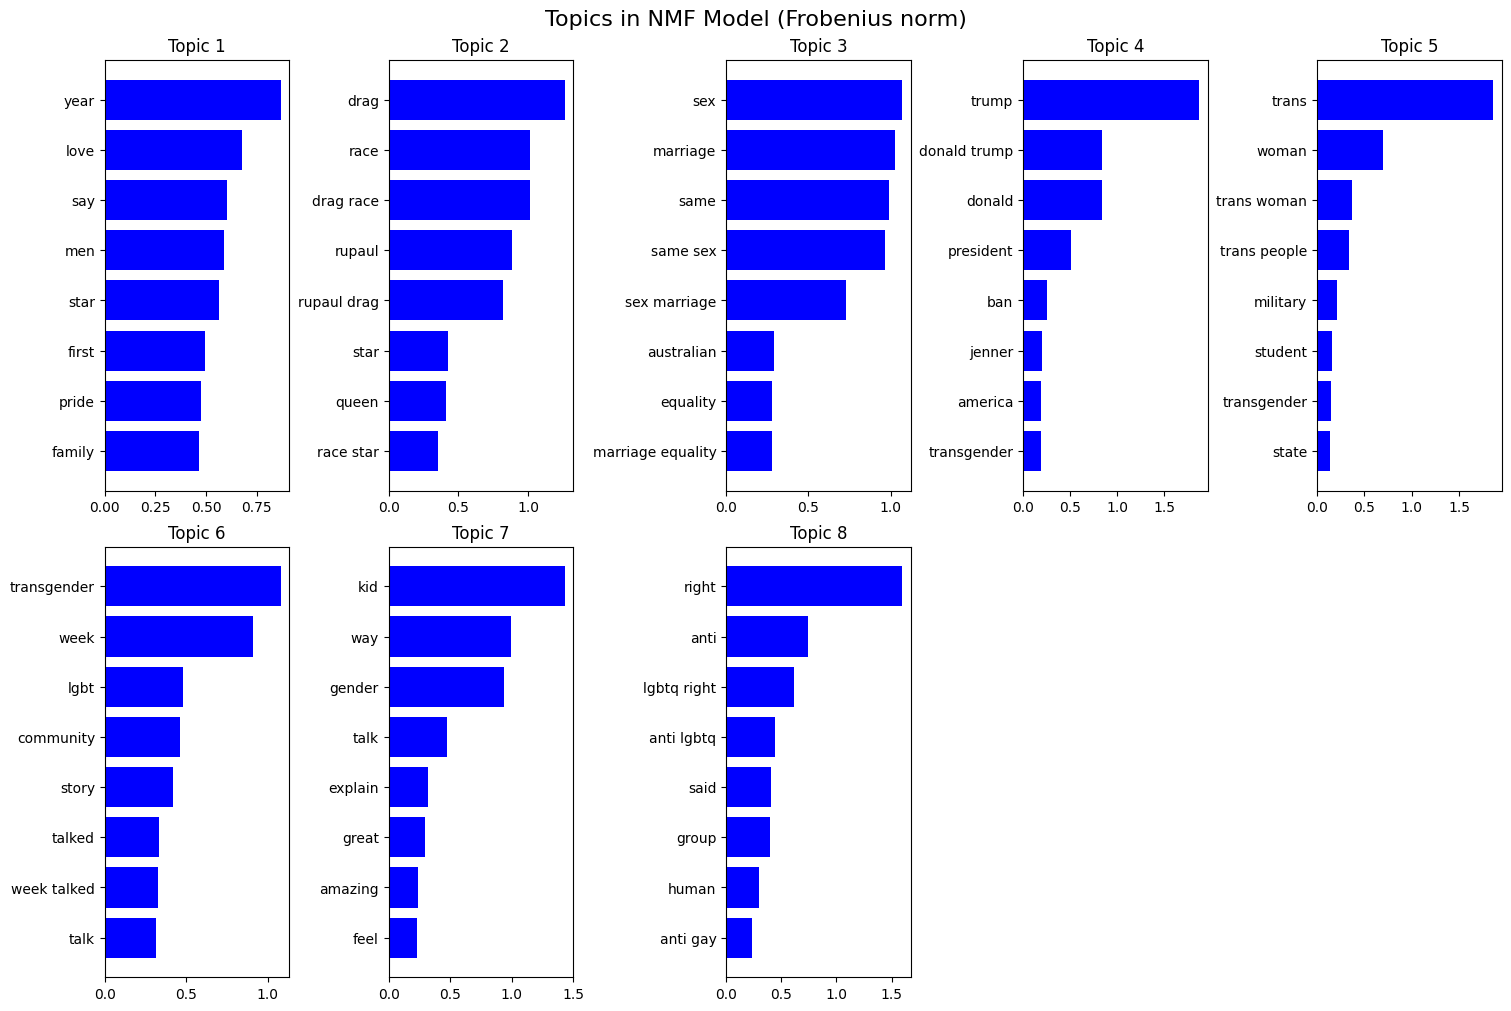

In [ ]:
if MODEL_TYPE == 'nmf':
    model_wrapper.plot_topics(n_top_words = 8)

## **Classify the docs, using the topic labels**

Each document is considered to contain a mix of different topics. Here, we find the topics in each text and label the text with the top two (**rank_1** and **rank_2**). We then separate out the topic number and name from the rank_1 topic. The resulting dataframe will later be used for outputting sample texts from the topics.

In [ ]:
%%time
# Classify the docs, using the topic labels.
model_wrapper.classify_docs()

# Display the first few lines of the df with the texts and the topics found in them.
display(model_wrapper.doc_classifications.head())

,headline_and_desc,rank_1,rank_2,top_topic_num,top_topic_name,top_topic_prob
0,Dear Queer America: Here Is What We Must Do No...,Topic 4 (1.0989),Topic 1 (1.0243),4,4: trump - donald trump - donald - president -...,0.098910
1,The Unclear Future of Trans Rights Under Trump...,Topic 5 (1.2068),Topic 8 (1.0497),5,5: trans - woman - trans woman - trans people ...,0.206849
2,A Gay Immigrant’s Perspective On Trump's Elect...,Topic 3 (1.0803),Topic 4 (1.0730),3,3: sex - marriage - same - same sex - sex marr...,0.080335
3,Here's An Amazing Resource For Helping Kids Un...,Topic 7 (1.1424),Topic 5 (1.0016),7,7: kid - way - gender - talk - explain - great,0.142427
4,New Exhibit Goes Behind Bars To Highlight Art ...,Topic 8 (1.0373),Topic 1 (1.0082),8,8: right - anti - lgbtq right - anti lgbtq - s...,0.037316


CPU times: user 18.2 s, sys: 55.7 s, total: 1min 13s
Wall time: 9.4 s


In [ ]:
# Generate and save a df with a sample of texts from each topic

# Generate the df
samples_from_each_topic = model_wrapper.get_n_texts_from_each_topic(5)

# File name
samples_filename = f'samples_from_each_topic_{timestamp}.csv'

# Save to disk
samples_from_each_topic.to_csv(os.path.join(GENERATED_DIR, samples_filename), index = False)

## **Output sample texts from chosen topic**

Here, we can output a choosen number of texts for a choosen topic number.

In [ ]:
# Output n samples from a selected topic number
model_wrapper.print_samples_from_topic(topic_num = 4, n = 5)

**4: trump - donald trump - donald - president - ban - jenner**

How One Texas Judge May Have Sealed The Fate Of LGBTQ Rights Under Donald Trump. The goal
is to make it acceptable to discriminate based on religious beliefs 



**4: trump - donald trump - donald - president - ban - jenner**

Caitlyn Jenner Reportedly Now Detests Donald Trump, Apologizes For Wearing MAGA Hat. "What
he's doing to our community is absolutely f***ing awful." 



**4: trump - donald trump - donald - president - ban - jenner**

Being A Transwoman In Trump's America. November 9th, 2016. Panic. Anger. Fear. How did
this happen? Wasn’t HB2 enough? Does anyone else know what I deal with, what 



**4: trump - donald trump - donald - president - ban - jenner**

Margaret Cho On Why Joking About Harvey Weinstein Is Exactly What We Need Now. The
comedian also sounds off on Trump and her own experience with sexual harassment. 



**4: trump - donald trump - donald - president - ban - jenner**

Trump's Attorney General Pick Opposes Hate Crime Laws And Roe v. Wade. Jeff Sessions has
also had to repeatedly defend racist comments he's made throughout his entire career. 



## **Evaluate topic coherence and diversity**

To aid our evaluation of the topics, we will now use three metrics: **c_v** and **c_npmi**, which measure topic coherence, i.e. how similar documents within a topic seem to be to each other, and **diversity**, which measures how distinct different topics are from each other.

The x-axis shows the number of topics. The y-axis shows the score. For all three metrics, a higher value is better.

### Coherence: c_v

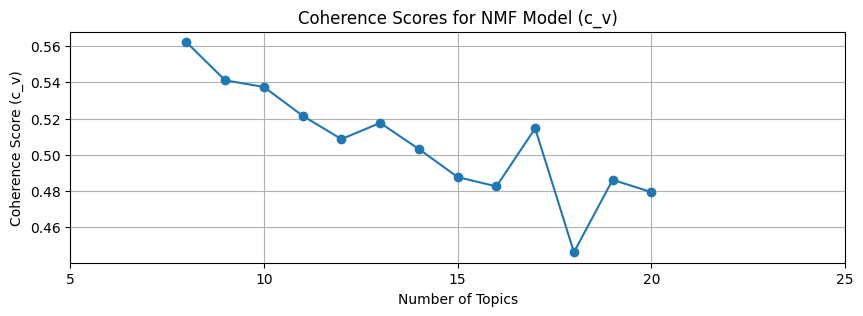


Best number of topics: 8
Max value: 0.562



In [ ]:
# Calculate and plot the c_v coherence score
scores_cv, c_v_best_n, c_v_max_value = evaluate_model(
    model_wrapper,
    metric = 'c_v',
    topics_range = range(TOPICS_RANGE_L, TOPICS_RANGE_H),
    top_n_words = TOP_N_WORDS)

### Coherence: c_npmi

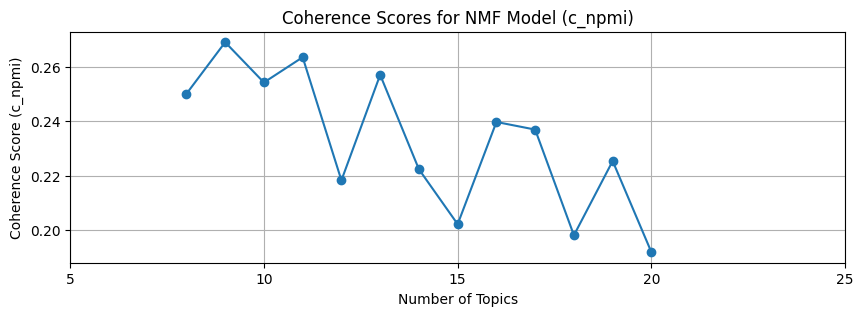


Best number of topics: 9
Max value: 0.269



In [ ]:
scores_c_npmi, c_npmi_best_n, c_npmi_max_value = evaluate_model(
    model_wrapper,
    metric = 'c_npmi',
    topics_range = range(TOPICS_RANGE_L, TOPICS_RANGE_H),
    top_n_words = TOP_N_WORDS)

### Diversity

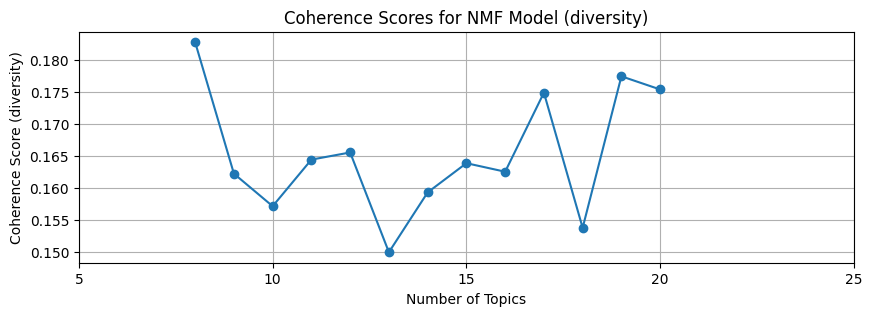


Best number of topics: 8
Max value: 0.183



In [ ]:
scores_diversity, diversity_best_n, diversity_max_value = evaluate_model(
    model_wrapper,
    metric = 'diversity',
    topics_range = range(TOPICS_RANGE_L, TOPICS_RANGE_H),
    top_n_words = TOP_N_WORDS)

# **Calculate the best number of topics**

The three graphs above typically don't agree on what is the best number of topics; the number of topics that gets the highest score on one metric is usually not the one that gets the highest score on the other two. But in the end, we need to select how many topics we want. Here, I'll do that automatically by combining the three metrics. To give them all equal weight, regardless of their scales, I min-max normalize the three scores and then take their average. The number of topics with the highest average should be the best compromise.

Now that we have choosen the best number of topics for the chosen model and configuration, we can set N_TOPICS in the configuration block to that number, and rerun the notebook to get the labels.

In [ ]:
scores = pd.DataFrame()
# c_v score
s_cv = pd.Series(scores_cv)
scores['c_v'] = s_cv
scores['c_v_norm'] = (s_cv - s_cv.min()) / (s_cv.max() - s_cv.min())

# c_npmi score
s_c_npmi = pd.Series(scores_c_npmi)
scores['c_npmi'] = s_c_npmi
scores['c_npmi_norm'] = (s_c_npmi - s_c_npmi.min()) / (s_c_npmi.max() - s_c_npmi.min())

# diversity score
s_diversity = pd.Series(scores_diversity)
scores['diversity'] = s_diversity
scores['diversity_norm'] = (s_diversity - s_diversity.min()) / (s_diversity.max() - s_diversity.min())

scores['avr_norm'] = (scores['c_v_norm'] + scores['c_npmi_norm'] + scores['diversity_norm']) / 3

display(scores)

max_avr_norm_score = scores['avr_norm'].max()
best_n = scores.loc[scores['avr_norm'] == max_avr_norm_score].index[0]

print(f"\nThe best number of topics, based on the three metrics, is {best_n}, which gets an average min-max normalized score of {max_avr_norm_score:.3f}.")

,c_v,c_v_norm,c_npmi,c_npmi_norm,diversity,diversity_norm,avr_norm
8,0.562158,1.000000,0.250004,0.754167,0.182708,1.000000,0.918056
9,0.541120,0.818584,0.268955,1.000000,0.162214,0.374115,0.730900
10,0.537458,0.787002,0.254176,0.808291,0.157138,0.219107,0.604800
11,0.521547,0.649808,0.263443,0.928498,0.164404,0.440992,0.673099
12,0.508645,0.538548,0.218246,0.342195,0.165518,0.475006,0.451916
13,0.517585,0.615640,0.256979,0.844647,0.149964,0.000000,0.486762
14,0.503158,0.491237,0.222316,0.394994,0.159291,0.284853,0.390361
15,0.487680,0.357764,0.202151,0.133422,0.163846,0.423950,0.305045
16,0.482534,0.313392,0.239679,0.620225,0.162516,0.383330,0.438982
17,0.514597,0.589871,0.236883,0.583956,0.174838,0.759650,0.644493



The best number of topics, based on the three metrics, is 8, which gets an average min-max normalized score of 0.918.


# **Save the results**

## **Save the results from the latest run**

Evaluating which model to use (LDA or NMF) and with which configuarations is a long process, which relies only partly on automatically generated metrics, like the c_v, c_npmi, and diversity metrics above. It also requires manual inspection of the topic lables and of samples of texts from each topic. The goal is to find a set of labels that make sense, are distinct from each other, and give us an idea about the texts belonging to the topic.

As is would be hard to do this in a single work session, I save the results from the last run of the notebook, along with the configurations, to disk.




In [ ]:
# Select n_topics for LDA and for NMF based on evaluation plots
choosen_n = int(best_n)

# Get the values for the choosen n_topics
c_v_for_choosen_n = float(scores_cv[choosen_n])
c_npmi_for_choosen_n = float(scores_c_npmi[choosen_n])
diversity_for_choosen_n = float(scores_diversity[choosen_n])

# Save the configs
configs_and_results = {
    'date_time': timestamp,
    'category': CATEGORY,
    'df_part': DF_PART,
    'model': MODEL_TYPE,
    'n_topics': N_TOPICS,
    'min_df': MIN_DF,
    'max_df': MAX_DF,
    'max_features': MAX_FEATURES,
    'max_n_grams': MAX_N_GRAMS,
    'custom_stopwords': [CUSTOM_STOPWORDS],
    'custom_non_stopwords': [CUSTOM_NON_STOPWORDS],
    'top_n_words': TOP_N_WORDS,
    'topics_range_l': TOPICS_RANGE_L,
    'topics_range_h': TOPICS_RANGE_H,
    # Placeholders, to get all columns in the desired order from the start
    'lambda_': "",
    'eta': "",
    'iterations': "",
    'passes': "",
    'solver': "",
    'init': "",
    'beta_loss': "",
    'nmf_alpha': "",
    'l1_ratio': "",
}

# LDA-specific configs
if MODEL_TYPE == 'lda':
    configs_and_results['lambda_'] = LAMBDA_
    configs_and_results['eta'] = ETA
    configs_and_results['iterations'] = ITERATIONS
    configs_and_results['passes'] = PASSES

# NMF-specific configs
if MODEL_TYPE == 'nmf':
    configs_and_results['solver'] = SOLVER
    configs_and_results['init'] = INIT
    configs_and_results['beta_loss'] = BETA_LOSS
    configs_and_results['nmf_alpha'] = NMF_ALPHA
    configs_and_results['l1_ratio'] = L1_RATIO

# Results
results = {
    'c_v_best_n': c_v_best_n,
    'c_v_max_value': c_v_max_value,
    'c_npmi_best_n': c_npmi_best_n,
    'c_npmi_max_value': c_npmi_max_value,
    'diversity_best_n': diversity_best_n,
    'diversity_max_value': diversity_max_value,
    'choosen_n': choosen_n,
    'c_v_for_choosen_n': c_v_for_choosen_n,
    'c_npmi_for_choosen_n': c_npmi_for_choosen_n,
    'diversity_for_chosen_n': diversity_for_choosen_n,
}

configs_and_results = configs_and_results | results

# File name for the config_and_results file
config_and_results_f = f'configs_and_results_{timestamp}.json'

# Generate a JSON object with the configs and the results.
with open(os.path.join(GENERATED_DIR, config_and_results_f), 'w') as f:
    json.dump(configs_and_results, f, indent = 4)

## **Aggregate results from all runs**

I now reload the files with configuations and results from disk and put them into a single dataframe, which I save back to disk.

In [ ]:
def aggregate_results_from_all_runs():
    """
    Aggregate configuration and result data from all JSON files in the results directory into a single Pandas DataFrame.

    This function reads all JSON files that match a specific naming pattern from the `GENERATED_DIR`,
    extracts configuration and result data, and combines them into a single Pandas DataFrame.
    The aggregated DataFrame is then saved to a CSV file and displayed.

    Returns:
    -------
    aggregated_results_df : pd.DataFrame
        A DataFrame containing the aggregated data from all runs, sorted by the 'date_time' column.

    Details:
    -------
    - The function filters JSON files with names starting with "configs_and_results" and ending with ".json".
    - Each JSON file contains configuration and result data for a single experiment.
    - Extracted data includes model configurations, evaluation metrics, and additional information.
    - The resulting DataFrame includes columns for key parameters and evaluation metrics across all runs.

    Output:
    -------
    - Saves the aggregated results as a CSV file in the `GENERATED_DIR`.
    - Displays the aggregated DataFrame for inspection.

    Columns in the DataFrame:
    -------------------------
    - 'date_time': Timestamp of the run.
    - 'category': The category of the dataset used for the run.
    - 'df_part': Partition of the dataset used.
    - 'model_type': Type of model used (e.g., 'lda', 'nmf').
    - 'n_topics': Number of topics used in the model.
    - Additional columns contain configurations (e.g., max features, stopwords) and evaluation metrics (e.g., coherence scores).

    Example Usage:
    --------------
    aggregated_results = aggregate_results_from_all_runs()
    print(aggregated_results.tail())
    """
    # List to store each run's data
    aggregated_results = []

    Create a df to hold the aggregated results
    cols = ['date_time', 'category', 'df_part', 'model_type', 'n_topics',\
            'min_df', 'max_df', 'max_features', 'max_n_grams', \
            'custom_stopwords', 'custom_non_stopwords', 'top_n_words', 'topics_range_l', 'topics_range_h', \
            'lambda_', 'eta', 'iterations', 'passes', \
            'solver', 'init', 'beta_loss', 'nmf_alpha', 'l1_ratio', \
            'c_v_best_n', 'c_v_max_value', 'c_npmi_best_n', 'c_npmi_max_value', 'diversity_best_n', 'diversity_max_value', \
            'choosen_n', 'c_v_for_choosen_n', 'c_npmi_for_choosen_n', 'diversity_for_chosen_n']

    aggregated_results = pd.DataFrame(columns = cols)

    # Loop through each file in the base directory
    for file in os.listdir(GENERATED_DIR):
        json_file_path = os.path.join(GENERATED_DIR, file)

        # Only proceed if it's a JSON file that starts with "config_and_results"
        if file.startswith("configs_and_results") and file.endswith(".json"):

            # Read the JSON file
            with open(json_file_path, 'r') as json_file:
                configs_and_results = json.load(json_file)

                aggregated_results.append(configs_and_results)

    # Convert the list of dictionaries into a Pandas DataFrame
    aggregated_results_df = pd.DataFrame(aggregated_results)

    # Sort dataframe by data_time
    aggregated_results_df.sort_values(by = 'date_time', inplace = True)

    # File name for the summary file
    aggregated_results_file_name = f'aggregated_results_df{timestamp}.csv'

    # Save the dataframe to a CSV file
    aggregated_results_df.to_csv(os.path.join(GENERATED_DIR, aggregated_results_file_name), index = False)

    # Display
    # display(aggregated_results)

    return aggregated_results_df

aggregate_results_from_all_runs().tail()

,date_time,category,df_part,model,n_topics,min_df,max_df,max_features,max_n_grams,custom_stopwords,...,c_v_best_n,c_v_max_value,c_npmi_best_n,c_npmi_max_value,diversity_best_n,diversity_max_value,choosen_n,c_v_for_choosen_n,c_npmi_for_choosen_n,diversity_for_chosen_n
41,2024-11-27_1958,QUEER VOICES,before,nmf,11,0.005,0.1,10000,2,"[[“, ‘]]",...,11,0.652864,11,0.274331,16,0.200822,11,0.652864,0.274331,0.134172
42,2024-11-27_2000,QUEER VOICES,before,nmf,11,0.005,0.1,10000,3,"[[“, ‘]]",...,9,0.656182,20,0.263303,15,0.205685,15,0.647701,0.246372,0.205685
43,2024-11-27_2002,QUEER VOICES,before,nmf,11,0.005,0.1,10000,2,"[[“, ‘]]",...,11,0.652864,11,0.274331,16,0.200822,11,0.652864,0.274331,0.134172
44,2024-11-27_2013,QUEER VOICES,after,nmf,10,0.005,0.1,10000,2,"[[“, ‘]]",...,10,0.626308,10,0.378913,11,0.207345,10,0.626308,0.378913,0.179821
45,2024-11-28_1056,QUEER VOICES,after,nmf,10,0.005,0.1,10000,2,"[[“, ‘, audio]]",...,8,0.562158,9,0.268955,8,0.182708,8,0.562158,0.250004,0.182708


# **Results and discussion**



As mentioned above, finding a good set of labels requires not just the use of automatically calculated metris, but also manual inspection of the labels and of texts belonging to each topic. The manual element in this makes it a time-consuming process. I've tweaked configuration parameters over scores of runs, but I'm still only moderately satisfied with the results. The difficulty in finding good labels may be due to the rather small size of the dataset: only some 6k text. In general, the smaller the dataset, the harder it is to deduce valid topics. The short lengths of the texts, with a median of just 30 words (including stopwords) may also contribute to the difficulty. Some of the labels include tokens that are too general to be meaningful, e.g. "day", "year", "say". (If I had more time, I would add these to the custom stopwords.) Others include tokens that are hard to make sense of without looking into the texts for context, e.g. "blood", "think", "talk". Working with longer texts, it would probably have been easier for the model to find distinctive, meaningful tokens to distinguish topics from each other.

In the end, I acchieved the most interpretable results with an NMF model with a rather small number of topics: 10 for the subset before the election, and 11 for the subset after.

In the table below, I compare the topics from the two subset with eath other. I've lined them up so that topics that appear in both sets are on the same line (and highlighted in green). I've also merged topics that seem very similar by putting them in the same cell (e.g. topics 2 and 7 in the "before" set). Note that this stage of topic-modeling work is not an exact science; deciding which topics to merge, and which ones in the "before" and "after" sets should be consider to correspond to each other requires judgement calls.

Out of the topics I found in the "after" set, I've highlighed in yellow the three that I found most interesting (and I grouped two of them together).




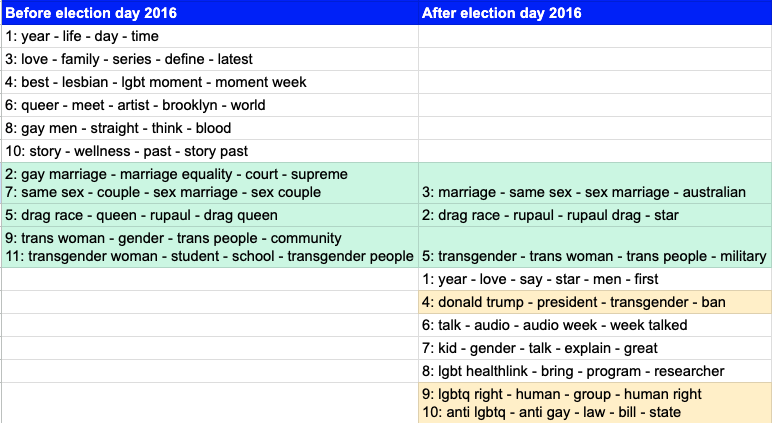

## **Samples from the most interesting topics in the "after" set**

I will now outpus a few samples of texts belonging to the three topics in the "after" set, that didn't appear in the "before" set, that I found most interesting.

In [ ]:
samples_after = pd.read_csv(os.path.join(GENERATED_DIR, 'samples_from_each_topic_2024-11-27_2013.csv'))

In [ ]:
topic_nums = [4, 9, 10]  # List of topic numbers to process
n = 5  # Number of examples to display per topic

for topic_num in topic_nums:
    # Filter for rows matching the current topic number
    samples = samples_after[samples_after['top_topic_num'] == topic_num].head(n)

    # Print the topic name once
    print_bold("-" * 50)
    print_bold(samples.iloc[0]['top_topic_name'])

    # Loop through the examples and print them with numbering
    for idx, row in enumerate(samples.itertuples(), start=1):
        text = textwrap.fill(row.headline_and_desc, width=90)
        print(f"{idx}. {text}\n")

**--------------------------------------------------**

**4: trump - donald trump - donald - president - transgender - ban**

1. 7 Anti-LGBTQ Moves The Trump Administration Has Made Already. The narrative that Trump is
a friend to the LGBTQA+ community has never made sense.

2. Trans Community Reacts To Trump’s Military Ban Tweets. Donald Trump tweeted Wednesday that
America would no longer “accept or allow” trans people to serve in the military. There’s

3. 'Pose' Picks Up Where 'Paris Is Burning' Left Off. A happy ending, perhaps, for the “Paris
is Burning” set who inspired it all.

4. The Election Inspired This Gay Hunter To Stop Hiding Who He Truly Is. Luke Zoesch
struggled to be authentic growing up in a rural, conservative environment.

5. HARDY: A Brand New Queer Zine. HARDY was launched in response to the turbulent socio-
political climate of 2016.



**--------------------------------------------------**

**9: right - lgbtq right - human - said - group - human right**

1. Religious Freedom And LGBTQ Rights Move From Battleground To Common Ground. Lakshman
Kalasapudi is a volunteer for SALGA-NYC, a non-profit organization serving the South Asian
LGBTQ community. He is

2. Obama Remembers LGBTQ Rights Icon Edie Windsor With Heartfelt Tribute. Hillary Clinton
also offered her condolences on Windsor's passing.

3. Abe Rybeck Talks The Theater Offensive and LGBT Civil Rights (AUDIO).

4. That 'Exclusively Gay' Moment In 'Beauty And The Beast' Wasn't Gay Enough. LeFou wasn't
written for the LGBTQ+ community -- it was encoded for a heterosexual gaze.

5. Something Simple You Can Do Right Now. I am on vacation this week. No daily grind, no
work, no responsibilities. Just what I needed! My husband and I (and our five



**--------------------------------------------------**

**10: anti - anti lgbtq - anti gay - law - bill - state**

1. Publix Accused Of Refusing To Cover HIV Prevention Drug For Staff. Some suggest the
supermarket chain denied the request on anti-LGBTQ grounds.

2. Washington State To Offer Non-Binary Option On Birth Certificates. The state will allow
people to identify as "male," "female," or "X."

3. Coachella's Owner Under Fire For Alleged Ties To Anti-LGBTQ Groups. Here's something to
consider before draining your bank account for tickets.

4. 'Family' Group Takes Its Anti-LGBTQ Crusade To The Global Stage. And they're counting on
Donald Trump to help them out.

5. The Satanic Temple Has An Ingenious Plan To Troll Anti-Gay Bakeries. Devil's food cake,
anyone?

